<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-MilepostAtTime-30min-MAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [2]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
#filename = "train-events-20-min.zip"

#Train reportings 15 minutes apart - everything we have collected
filename = "train-data-master-2.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 90.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 30.0 }
dep_var = 'nextValue'

#Determines the portion of data to train versus validate
dataCutpoint = .80

In [3]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-master-2.zip...
| [1 files][342.4 MiB/342.4 MiB]                                                
Operation completed over 1 objects/342.4 MiB.                                    


In [4]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   22:24:15
2000   22:24:24
3000   22:24:35
4000   22:24:39
5000   22:24:45
6000   22:24:50
7000   22:24:55
8000   22:24:59
9000   22:25:04
10000   22:25:09
11000   22:25:14
12000   22:25:20
13000   22:25:23
14000   22:25:29
15000   22:25:34
16000   22:25:38
17000   22:25:44
18000   22:25:48
19000   22:25:54
20000   22:25:58
21000   22:26:05
22000   22:26:10
23000   22:26:14
24000   22:26:20
25000   22:26:24
26000   22:26:31
27000   22:26:35
28000   22:26:38
29000   22:26:46
30000   22:26:49
31000   22:26:53
32000   22:26:57
33000   22:27:04
34000   22:27:08
35000   22:27:12
36000   22:27:15
37000   22:27:23
38000   22:27:27
39000   22:27:31
40000   22:27:35
41000   22:27:43
42000   22:27:47
43000   22:27:51
44000   22:27:55
45000   22:27:59
46000   22:28:08
47000   22:28:12
48000   22:28:16
49000   22:28:20
50000   22:28:23
51000   22:28:33
52000   22:28:37
53000   22:28:40
54000   22:28:44
55000   22:28:48


In [5]:
dfTrainsAll = pd.concat(trains.values())

In [6]:
del trains

In [7]:
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

Filter out MP outside of Boone

In [8]:
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] < 327]
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] > 201]


In [9]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45739 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            45739 non-null  object 
 1   positionHistoryList                                            45739 non-null  object 
 2   locomotiveList                                                 45739 non-null  object 
 3   subdivisionList                                                45739 non-null  object 
 4   trainEstimatedPositionList                                     45739 non-null  object 
 5   trainActualPositionList                                        45739 non-null  object 
 6   trainId.trainSCAC                                              45691 non-null  object 
 7   trainId.trainSection                                          

# Create a learning set to modify

In [10]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [11]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [12]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [13]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


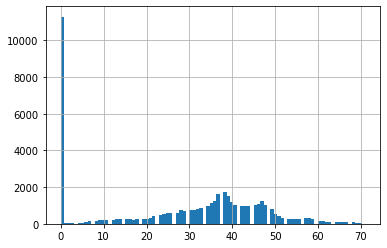

In [14]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [15]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [16]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [17]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['M' 'U' 'E' 'G' 'C' 'A' 'I' 'W' 'Z' 'S' 'L' 'P']
['MT 1' 'MT 2' 'EASTXO' 'N SIDING' 'WESTXO' 'YD LD' '136' 'XO' '806' '405' '113']
['UP' 'UNK']
['' '2']
[4. 1. 3. 0.]
[12.  8. 15.  4.  2. 10. 19. 17. 11. 14.  0.]
[2. 1. 0.]
[2. 3. 0.]
['' 0.0]
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [18]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[60. 70. 50. 40. 88. 45. 79.  0. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [19]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [20]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [21]:
dfTrainsLearn['workLocations'].unique()

array(['202.20', '258.40,202.20', None, '225.10', '202.20,258.40,321.50', '314.52,202.20', '321.50,202.20', '231.80,225.10', '214.50', '225.10,202.20', '202.20,258.40', '202.20,219.70',
       '219.70,202.20', '202.20,214.50,225.10,290.80,304.10', '202.20,258.40,225.10', '202.20,219.90,225.10', '202.20,257.60', '250.50,202.20', '268.40,202.20', '258.40,207.60,202.20',
       '207.60,202.20', '241.00,202.20', '258.40,219.70,202.20', '202.20,314.52', '202.92,202.20', '214.50,225.10,290.80,304.10,202.20', '290.80,258.40,231.80,202.20', '202.20,290.80',
       '202.20,299.75', '314.52,225.10,202.20', '202.20,219.70,277.50', '202.20,293.10', '202.20,304.10', '321.50,314.52,202.20', '202.20,240.90', '202.20,265.30', '265.30,202.20', '202.20,286.40',
       '240.90,207.60,202.20', '250.50,245.90,202.20', '219.70', '202.20,312.80', '321.50,240.90,202.20', '240.90,202.20', '202.20,207.60', '202.20,225.10', '326.20,214.50', '214.50,202.20',
       '240.90,214.50,202.20', '278.10,258.40,202.20', 

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [22]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [23]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [24]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.subdivisionId'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.trackName'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])

You can peer into the incoming data here:

In [25]:
idx = 1
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

NS1007
MGBNP
106
MT 1
209.8707


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-09T19:40:07Z,0,106,MT 1,209.87070
1,2022-06-09T19:42:07Z,0,106,MT 1,209.87070
2,2022-06-09T19:44:07Z,5,106,MT 1,210.15358
3,2022-06-09T19:46:07Z,11,106,MT 1,210.46217
4,2022-06-09T19:48:07Z,17,106,MT 1,210.88560
...,...,...,...,...,...
52,2022-06-09T21:26:07Z,35,106,MT 1,281.16560
53,2022-06-09T21:28:07Z,42,106,MT 1,282.40717
54,2022-06-09T21:30:07Z,49,106,MT 1,283.95746
55,2022-06-09T21:34:07Z,62,106,MT 1,287.82657


In [26]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,202.2072,"[{'positionTime': '2022-06-09T19:20:40Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 202.2072}}}, {'positionTime': '2022-06-09T19:22:40Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.70474}}}, {'positionTime': '2022-06-09T19:24:40Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 205.29929}}}, {'positionTime': '2022-06-09T19:26:40Z', 'speedMPH': 53, 'milepostLocation': {'subdivisionId': 106..."
0,209.8707,[]
0,216.5130,"[{'positionTime': '2022-06-09T19:54:41Z', 'speedMPH': 26, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 216.513}}}, {'positionTime': '2022-06-09T19:56:41Z', 'speedMPH': 32, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 217.47511}}}, {'positionTime': '2022-06-09T19:58:41Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 218.65654}}}, {'positionTime': '2022-06-09T20:00:41Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106,..."
0,224.2101,"[{'positionTime': '2022-06-09T20:11:30Z', 'speedMPH': 31, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 224.2101}}}, {'positionTime': '2022-06-09T20:13:30Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 225.32594}}}, {'positionTime': '2022-06-09T20:15:30Z', 'speedMPH': 41, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 226.61711}}}, {'positionTime': '2022-06-09T20:17:30Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106..."
0,235.8908,"[{'positionTime': '2022-06-09T20:27:41Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 235.8908}}}, {'positionTime': '2022-06-09T20:29:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 237.54869}}}, {'positionTime': '2022-06-09T20:31:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 238.9238}}}, {'positionTime': '2022-06-09T20:33:41Z', 'speedMPH': 44, 'milepostLocation': {'subdivisionId': 106,..."
...,...,...
0,229.3058,"[{'positionTime': '2022-05-31T11:08:37Z', 'speedMPH': -62, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 229.3058}}}, {'positionTime': '2022-05-31T11:10:37Z', 'speedMPH': -68, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 227.14987}}}, {'positionTime': '2022-05-31T11:12:37Z', 'speedMPH': -70, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 224.82933}}}, {'positionTime': '2022-05-31T11:14:37Z', 'speedMPH': -70, 'milepostLocation': {'subdivisionId':..."
0,217.1557,"[{'positionTime': '2022-05-31T11:24:36Z', 'speedMPH': -20, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 217.1557}}}, {'positionTime': '2022-05-31T11:26:36Z', 'speedMPH': -36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 216.23074}}}, {'positionTime': '2022-05-31T11:28:36Z', 'speedMPH': -48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 214.81465}}}, {'positionTime': '2022-05-31T11:30:36Z', 'speedMPH': -57, 'milepostLocation': {'subdivisionId':..."
0,204.3378,"[{'positionTime': '2022-05-31T11:41:31Z', 'speedMPH': -8, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 204.3378}}}, {'positionTime': '2022-05-31

Renumber the list

In [27]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [28]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return (abs(actualsEntry.iloc[idx]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
  return None

In [29]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [30]:
def findNextMilepostAtTime(trainsEntry, actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]['milepostLocation.milepost.milepostNumber']
  return None

In [31]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(trainsEntry, actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [32]:
idx = 3291
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 1)
print("Next Speed at MP:",nextActual)
nextActual = findNextTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Next Speed at 10 Min:",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Milepost in 10 Min:",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, 1)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

UP2706
MCHCB
106
MT 2
320.4698
Reported speed:  39
Reported MP:  320.4698
Reported Time:  2022-05-11T10:25:35Z
Next Speed at MP:            positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-05-11T10:27:35Z        38                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 2                                 321.73276  
Next Speed at 10 Min: -39
Milepost in 10 Min: 325.6992
actual Value:  325.699
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-05-11T10:27:35Z        40                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 2                                 321.80084  
beop Value:  344.286


Run the calulations.  This will take a moment.

In [33]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(trainsEntry, beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


In [34]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([215.53906, 223.57376, 235.31651, ..., 216.9826 , 204.64708, 202.5429 ])

NextValue values histogram:


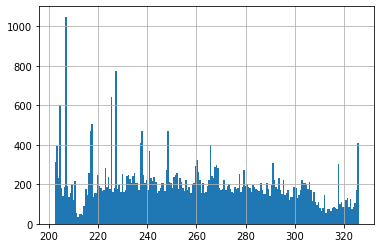

In [35]:
print("NextValue values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [36]:
dfTrainsLearn['beopValue'].unique()

array([233.54254,       nan, 240.27034, ..., 204.24977, 191.52751, 227.83861])

physics predictions histogram:


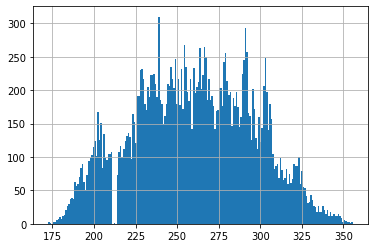

In [37]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [38]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [39]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [40]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,NS1007,UP,,MGBNP,...,False,False,False,1.654802e+09
1,NS1007,UP,,MGBNP,...,False,False,False,1.654803e+09
2,NS1007,UP,,MGBNP,...,False,False,False,1.654804e+09
3,NS1007,UP,,MGBNP,...,False,False,False,1.654805e+09
4,NS1007,UP,,MGBNP,...,False,False,False,1.654806e+09
...,...,...,...,...,...,...,...,...,...
45731,UP9098,UP,,ZLTG2,...,False,False,False,1.653993e+09
45732,UP9098,UP,,ZLTG2,...,False,False,False,1.653993e+09
45733,UP9098,UP,,ZLTG2,...,False,False,False,1.653994e+09
45734,UP9098,UP,,ZLTG2,...,False,False,False,1.653995e+09


In [41]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(40073, 47)
(45739,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40073 entries, 0 to 45737
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            40073 non-null  object        
 1   trainId.trainSCAC                                              40073 non-null  category      
 2   trainId.trainSection                                           40073 non-null  category      
 3   trainId.trainSymbol                                            40073 non-null  object        
 4   trainId.trainDate                                              40073 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  40073 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            40073 non-

# Use Decision Tree to predict next value

In [42]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [43]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
90      88
91     294
92     337
93     357
94     256
      ... 
184    310
185    417
186    349
187    502
188      9
Name: lastReportedPosition.positionTimeDayofyear, Length: 98, dtype: int64


In [44]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * dataCutpoint)])

We will partition this set at day of year: 168


In [45]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * dataCutpoint)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [46]:
#dep_var = 'nextSpeed'

In [47]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [48]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [49]:
len(to.train),len(to.valid)

(33168, 6905)

In [50]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
0,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,42,202.207199,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,60.0,102.0,0.0,9738.0,7158.0,202,2,6,23,9,3,160,1.654802e+09,215.539062
1,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,0,209.870697,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,209,2,6,23,9,3,160,1.654803e+09,223.573761
2,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,26,216.513000,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,216,2,6,23,9,3,160,1.654804e+09,235.316513
3,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,31,224.210098,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,224,2,6,23,9,3,160,1.654806e+09,246.743423
4,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,36,235.890793,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,235,2,6,23,9,3,160,1.654806e+09,260.126495
5,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,62,246.540100,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,246,2,6,23,9,3,160,1.654807e+09,271.050568
6,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,50,260.289795,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,260,2,6,23,9,3,160,1.654808e+09,285.541382
7,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,59,272.092896,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,272,2,6,23,9,3,160,1.654809e+09,305.831238
8,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,58,285.755707,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,285,2,6,23,9,3,160,1.654810e+09,319.314545
31,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,33,202.206802,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0

In [51]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating a Decision Tree

In [52]:
to = fastai.load_pickle('/tmp/to.pkl')

In [53]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [54]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

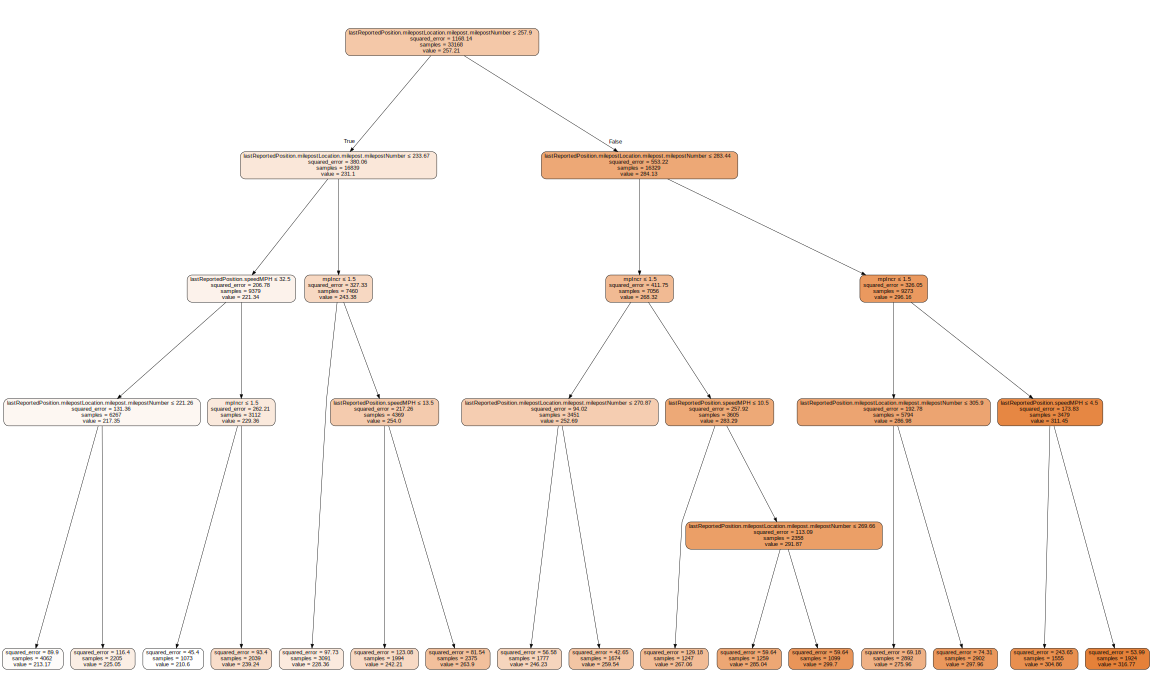

In [55]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [56]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

In [57]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

How well we fit the training model:

In [58]:
trainingPreds = m.predict(xs)
r_mse(trainingPreds, y)

4.304849

How well we fit the Validation Model:

In [59]:
validationPreds = m.predict(valid_xs)
r_mse(validationPreds, valid_y)

6.344967

In [60]:
def showPredictions(predictionsSeries, validSeries):
  b = predictionsSeries.reset_index(drop=true)
  y = validSeries.reset_index(drop=true)
  df  = pd.concat([b, y], axis=1)
  df = df.dropna()
  df.rename(columns={ df.columns[0]: "prediction", df.columns[1]: "actual" }, inplace = True)
  print(df)
  print("RMSE: ", r_mse(df.iloc[:,0], df.iloc[:,1]))

Simple Decision Tree Predictions:

In [61]:
showPredictions(pd.DataFrame(validationPreds), valid_y)

      prediction      actual
0     306.638173  303.640961
1     292.804802  294.448029
2     284.547177  291.374786
3     272.956571  289.952820
4     288.550669  281.968353
...          ...         ...
6900  228.245928  226.313950
6901  227.180734  218.931168
6902  211.523100  207.865692
6903  211.523100  203.052094
6904  203.366471  202.542892

[6905 rows x 2 columns]
RMSE:  6.344967


In [62]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [63]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.814500
12,mpIncr,0.127371
22,lastReportedPosition.speedMPH,0.046143
3,trainId.trainSymbol,0.002060
24,aotuTrainData.totalCarWeight,0.000679
36,trainLength,0.000619
45,lastReportedPosition.positionTimeElapsed,0.000615
0,ptcLeadLocomotiveId,0.000614
42,lastReportedPosition.positionTimeDay,0.000581
34,loadedCarCount,0.000577


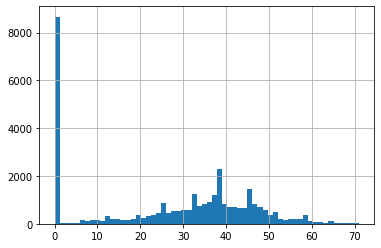

In [64]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


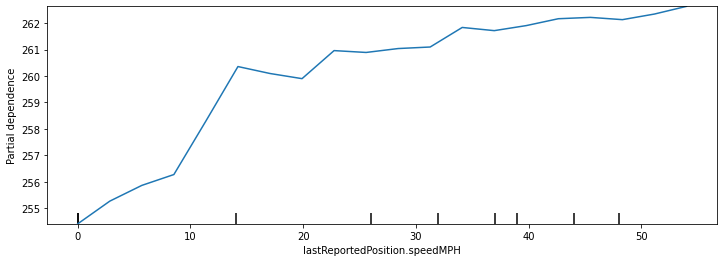

In [65]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

#Random Forest

In [66]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [67]:
m = randomForest(xs, y);

In [68]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(5.604418, 5.802601)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Random Forest Predictions:

In [70]:
showPredictions(pd.DataFrame(preds.mean(0)), valid_y)


      prediction      actual
0     305.540787  303.640961
1     292.875211  294.448029
2     286.678920  291.374786
3     274.786241  289.952820
4     291.254177  281.968353
...          ...         ...
6900  227.088058  226.313950
6901  220.128477  218.931168
6902  211.191538  207.865692
6903  209.295371  203.052094
6904  207.009167  202.542892

[6905 rows x 2 columns]
RMSE:  5.802601


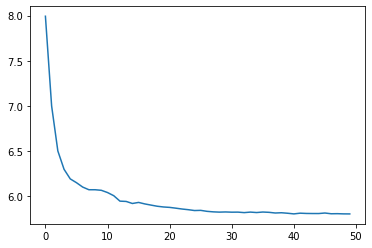

In [71]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [72]:
r_mse(m.oob_prediction_, y)

5.823467

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [74]:
preds.shape

(50, 6905)

In [75]:
preds_std = preds.std(0)

In [76]:
preds_std[:5]

array([ 3.04478144,  4.3316216 ,  5.59740493,  3.71689455, 11.55662959])

# FEATURE Importance

In [77]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.587564
38,milepost,0.223136
12,mpIncr,0.109059
22,lastReportedPosition.speedMPH,0.046648
6,lastReportedPosition.milepostLocation.trackName,0.005195
3,trainId.trainSymbol,0.004688
14,workLocations,0.002937
36,trainLength,0.001765
37,trailingTonnage,0.001705
24,aotuTrainData.totalCarWeight,0.001659


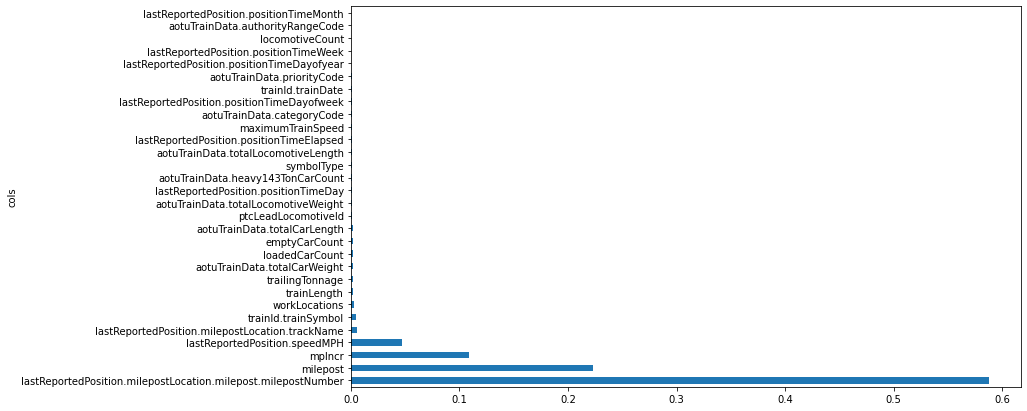

In [78]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [79]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

27

In [80]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [81]:
m = randomForest(xs_imp, y)

In [82]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(5.626683, 5.830479)

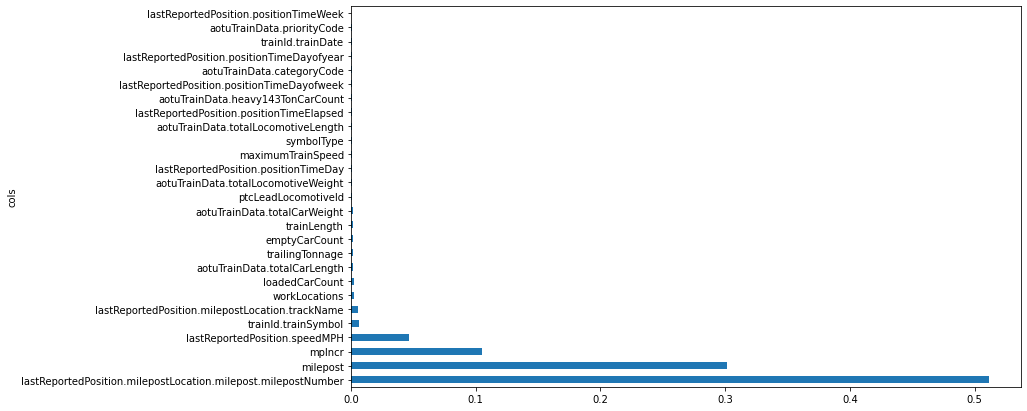

In [83]:
plot_fi(rf_feat_importance(m, xs_imp));

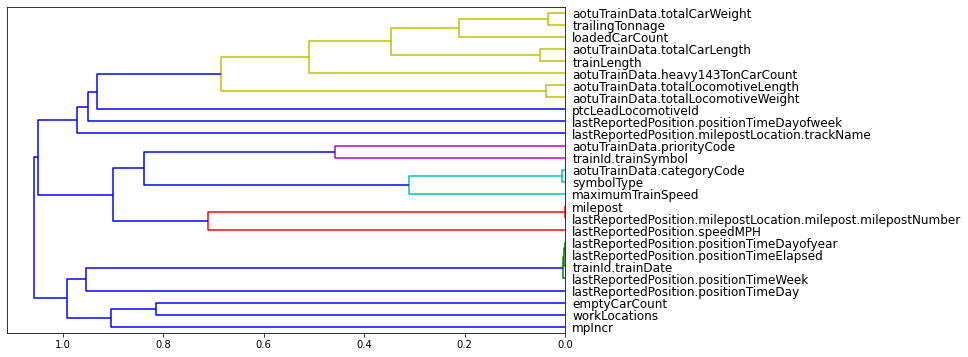

In [84]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [85]:
showPredictions(dfTrainsNextBeop.tail(len(valid_y)), valid_y)

      prediction      actual
0      238.82120  303.640961
1      221.28871  294.448029
2      202.96020  291.374786
3      192.82454  289.952820
5      291.79752  274.340546
...          ...         ...
6900   232.41292  226.313950
6901   221.17844  218.931168
6902   204.24977  207.865692
6903   191.52751  203.052094
6904   227.83861  202.542892

[4069 rows x 2 columns]
RMSE:  49.700437


# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [86]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.469082
45,lastReportedPosition.positionTimeElapsed,0.337062
41,lastReportedPosition.positionTimeWeek,0.099524
4,trainId.trainDate,0.090189
42,lastReportedPosition.positionTimeDay,0.003904
40,lastReportedPosition.positionTimeMonth,0.000239
33,maximumTrainSpeed,0.000000
26,aotuTrainData.totalLocomotiveWeight,0.000000


Consider whether these values make sense

#Using a Neural Net

In [87]:
df_nn_final = dfTrainsLearn

In [88]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40073 entries, 0 to 45737
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            40073 non-null  object        
 1   trainId.trainSCAC                                              40073 non-null  category      
 2   trainId.trainSection                                           40073 non-null  category      
 3   trainId.trainSymbol                                            40073 non-null  object        
 4   trainId.trainDate                                              40073 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  40073 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            40073 non-null  int64         


In [89]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [90]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [91]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    1486
trainId.trainSCAC                                         2
trainId.trainSection                                      2
trainId.trainSymbol                                     413
trainId.trainDate                                       105
lastReportedPosition.speedMPH                            72
lastReportedPosition.milepostLocation.subdivisionId       1
lastReportedPosition.milepostLocation.trackName          11
aotuTrainData.priorityCode                                4
aotuTrainData.categoryCode                               11
aotuTrainData.authorityRangeCode                          3
aotuTrainData.ownershipCode                               3
aotuTrainData.eventCode                                   1
milepost                                                123
mpIncr                                                    2
symbolType                                               12
workLocations                           

In [92]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [93]:
dls = to_nn.dataloaders(1024)

In [94]:
y = to_nn.train.y
y.min(),y.max()

(202.2169, 326.09528)

In [100]:
learn = tabular_learner(dls, y_range=(202,327), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0004786300996784121)

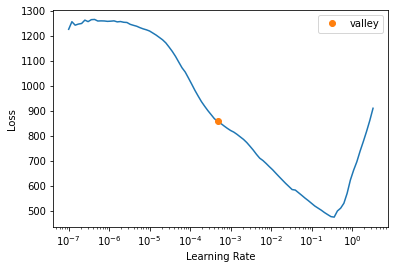

In [101]:
learn.lr_find()

In [102]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,time
0,448.325623,611.215271,00:02
1,333.046509,286.487885,00:02
2,242.633606,149.930542,00:02
3,163.439194,96.635765,00:02
4,113.220291,85.069801,00:02
5,83.371666,77.098534,00:02
6,70.248177,64.703506,00:02
7,68.501183,80.618561,00:02
8,57.936569,57.163509,00:02
9,51.386551,56.851627,00:02


NN Predictions:

In [103]:
preds,targs = learn.get_preds()
showPredictions(pd.DataFrame(preds.numpy()), pd.DataFrame(targs.numpy()))

          actual      actual
0     306.309814  303.640961
1     295.641937  294.448029
2     285.813568  291.374786
3     277.050842  289.952820
4     280.111206  281.968353
...          ...         ...
6900  238.392227  226.313950
6901  227.742767  218.931168
6902  220.986252  207.865692
6903  214.048798  203.052094
6904  205.225052  202.542892

[6905 rows x 2 columns]
RMSE:  7.5419
